---
## 1. Import Libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)

print("✓ Libraries imported successfully!")
print("\nBaseline Model: Linear Regression (Simplified - 28 Features)")

✓ Libraries imported successfully!

Baseline Model: Linear Regression (Simplified - 28 Features)


---
## 2. Load Pre-Split Data

- **test_data.csv**: 01.08.2018 to 31.07.2019

Using pre-split datasets from the data preparation phase:- **val_data.csv**: 01.08.2017 to 31.07.2018
- **train_data.csv**: 01.07.2013 to 31.07.2017

In [66]:
# Load pre-split datasets
data_path = '/workspaces/Room_7_Bakery_Prediction/0_DataPreparation/0.6 Merge with test dataset and split/'

train_data = pd.read_csv(data_path + 'train_data.csv')
val_data = pd.read_csv(data_path + 'val_data.csv')
test_data = pd.read_csv(data_path + 'test_data.csv')

# Convert date columns
train_data['date'] = pd.to_datetime(train_data['date'])
val_data['date'] = pd.to_datetime(val_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data.head()

print("="*80)

print("DATA LOADED")
print(f"   Has sales: {test_data['umsatz'].notna().sum():,} rows (for prediction)")

print("="*80)
print(f"   Date range: {test_data['date'].min().date()} to {test_data['date'].max().date()}")

print(f"\n📊 TRAINING SET:")
print(f"   Shape: {test_data.shape[0]:,} rows × {test_data.shape[1]} columns")

print(f"   Shape: {train_data.shape[0]:,} rows × {train_data.shape[1]} columns")
print(f"\n📊 TEST SET:")

print(f"   Date range: {train_data['date'].min().date()} to {train_data['date'].max().date()}")

print(f"   Has sales: {train_data['umsatz'].notna().sum():,} rows")
print(f"   Has sales: {val_data['umsatz'].notna().sum():,} rows")

print(f"   Date range: {val_data['date'].min().date()} to {val_data['date'].max().date()}")

print(f"\n📊 VALIDATION SET:")
print(f"   Shape: {val_data.shape[0]:,} rows × {val_data.shape[1]} columns")

DATA LOADED
   Has sales: 0 rows (for prediction)
   Date range: 2018-08-01 to 2019-07-30

📊 TRAINING SET:
   Shape: 1,830 rows × 50 columns
   Shape: 7,493 rows × 50 columns

📊 TEST SET:
   Date range: 2013-07-01 to 2017-07-31
   Has sales: 7,493 rows
   Has sales: 1,841 rows
   Date range: 2017-08-01 to 2018-07-31

📊 VALIDATION SET:
   Shape: 1,841 rows × 50 columns


---
## 3. Data Cleaning & Preparation

2. Apply time-aware imputation for missing values

Data is already split, now we'll:1. Drop lag features to prevent data leakage

In [67]:
print("Preparing data...\n")

# Combine train and val for cleaning (we'll keep them separate after)
df_with_sales = pd.concat([train_data, val_data], ignore_index=True)
df_without_sales = test_data.copy()

print(f"Training + Validation data: {len(df_with_sales):,} rows")
print(f"Test data: {len(df_without_sales):,} rows")

# Drop lag features (prevent data leakage)
lag_cols = [col for col in df_with_sales.columns if any(x in col.lower() for x in ['lag', '_ma', 'volatility', 'pct_change', 'sum_7d'])]
if 'id' in df_with_sales.columns:
    lag_cols.append('id')

print(f"\nDropping {len(lag_cols)} lag features to prevent data leakage")

df_with_sales = df_with_sales.drop(columns=lag_cols, errors='ignore')
df_without_sales = df_without_sales.drop(columns=lag_cols, errors='ignore')

# === Time-aware imputation (uses only past info, no future peeking) ===
print("\nApplying time-aware imputation for weather features...")

# Ensure month column exists for fallback
if 'month' not in df_with_sales.columns:
    df_with_sales['month'] = df_with_sales['date'].dt.month
if 'month' not in df_without_sales.columns:
    df_without_sales['month'] = df_without_sales['date'].dt.month

# Identify weather columns
numeric_weather_cols = [c for c in ['Temperatur', 'Niederschlag', 'Windgeschwindigkeit', 
                                     'Luftdruck', 'Luftfeuchte', 'Sonnenscheindauer', 'Bewoelkung'] 
                        if c in df_with_sales.columns]
has_wettercode_cat = 'wettercode_category' in df_with_sales.columns
has_wettercode_num = 'Wettercode' in df_with_sales.columns

# Helper: sort by Warengruppe + date for proper time order
group_col = 'Warengruppe' if 'Warengruppe' in df_with_sales.columns else None

def sort_temporal(df_):
    if group_col and group_col in df_.columns:
        return df_.sort_values([group_col, 'date'])
    return df_.sort_values('date')

def ffill_by_group(df_, col):
    if group_col and group_col in df_.columns:
        df_[col] = df_.groupby(group_col, observed=True)[col].ffill()
    else:
        df_[col] = df_[col].ffill()

# Sort both dataframes
df_with_sales = sort_temporal(df_with_sales)
df_without_sales = sort_temporal(df_without_sales)

# 1) Numeric weather: forward fill, then per-month median fallback (computed on training data)
for col in numeric_weather_cols:
    # Ensure numeric
    df_with_sales[col] = pd.to_numeric(df_with_sales[col], errors='coerce')
    df_without_sales[col] = pd.to_numeric(df_without_sales[col], errors='coerce')
    
    # Forward fill by group
    ffill_by_group(df_with_sales, col)
    ffill_by_group(df_without_sales, col)
    
    # Month-based fallback using training data statistics
    month_medians = df_with_sales.groupby('month')[col].median()
    global_median = df_with_sales[col].median()
    
    for df_ in [df_with_sales, df_without_sales]:
        missing = df_[col].isna()
        if missing.any():
            df_.loc[missing, col] = df_.loc[missing, 'month'].map(month_medians)
            still_missing = df_[col].isna()
            if still_missing.any():
                df_.loc[still_missing, col] = global_median
    
    # Special: Bewoelkung is Okta (0-9), round and clip
    if col == 'Bewoelkung':
        df_with_sales[col] = np.round(df_with_sales[col]).clip(0, 9)
        df_without_sales[col] = np.round(df_without_sales[col]).clip(0, 9)
        # Convert to int if no NaNs left
        if df_with_sales[col].isna().sum() == 0:
            df_with_sales[col] = df_with_sales[col].astype(int)
        if df_without_sales[col].isna().sum() == 0:
            df_without_sales[col] = df_without_sales[col].astype(int)

# 2) Wettercode: handle numeric and categorical in sync
if has_wettercode_num or has_wettercode_cat:
    # WMO code mapping
    wmo_map = {
        0.0: "Cloud development not observed or not observable",
        3.0: "Clouds generally forming or developing",
        5.0: "Haze",
        10.0: "Mist",
        17.0: "Thunderstorm, no precipitation at observation",
        20.0: "Drizzle (not freezing) or snow grains",
        21.0: "Rain (not freezing)",
        22.0: "Snow",
        28.0: "Fog or ice fog",
        45.0: "Fog or ice fog, sky invisible",
        49.0: "Fog, depositing rime, sky invisible",
        53.0: "Moderate drizzle, not freezing, continuous",
        55.0: "Heavy drizzle, not freezing, continuous",
        61.0: "Slight rain, not freezing, intermittent",
        63.0: "Moderate rain, not freezing, continuous",
        65.0: "Heavy rain, not freezing, continuous",
        68.0: "Rain or drizzle and snow, slight",
        69.0: "Rain or drizzle and snow, moderate or heavy",
        71.0: "Slight continuous fall of snowflakes",
        73.0: "Moderate continuous fall of snowflakes",
        75.0: "Heavy continuous fall of snowflakes",
        77.0: "Snow grains (with or without fog)",
        79.0: "Ice pellets",
        95.0: "Thunderstorm, slight/moderate, no hail but rain/snow"
    }
    
    # Ensure numeric
    df_with_sales['Wettercode'] = pd.to_numeric(df_with_sales['Wettercode'], errors='coerce')
    df_without_sales['Wettercode'] = pd.to_numeric(df_without_sales['Wettercode'], errors='coerce')
    
    # Forward fill by group
    ffill_by_group(df_with_sales, 'Wettercode')
    ffill_by_group(df_without_sales, 'Wettercode')
    
    # Month mode fallback (using only observed values)
    month_modes = df_with_sales.groupby('month')['Wettercode'].apply(
        lambda x: x.dropna().mode().iloc[0] if len(x.dropna().mode()) > 0 else None
    )
    global_mode = df_with_sales['Wettercode'].dropna().mode()
    global_mode = global_mode.iloc[0] if len(global_mode) > 0 else 0.0  # Default to clear sky instead of rain
    
    for df_ in [df_with_sales, df_without_sales]:
        missing = df_['Wettercode'].isna()
        if missing.any():
            df_.loc[missing, 'Wettercode'] = df_.loc[missing, 'month'].map(month_modes)
            still_missing = df_['Wettercode'].isna()
            if still_missing.any():
                df_.loc[still_missing, 'Wettercode'] = global_mode
    
    # NOW sync wettercode_category from the (possibly filled) Wettercode
    df_with_sales['wettercode_category'] = df_with_sales['Wettercode'].map(wmo_map)
    df_without_sales['wettercode_category'] = df_without_sales['Wettercode'].map(wmo_map)
    
    # Fill any still-missing categories with 'Unknown'
    df_with_sales['wettercode_category'].fillna('Unknown', inplace=True)
    df_without_sales['wettercode_category'].fillna('Unknown', inplace=True)
    
    print(f"  ✓ Wettercode filled and synced to wettercode_category")
    print(f"    Train Wettercode NaNs: {df_with_sales['Wettercode'].isna().sum()}")
    print(f"    Train wettercode_category NaNs: {df_with_sales['wettercode_category'].isna().sum()}")

# 3) Fill remaining non-weather columns with simpler logic
for col in df_with_sales.columns:
    # Check if EITHER dataset has missing values
    has_missing = df_with_sales[col].isnull().sum() > 0 or df_without_sales[col].isnull().sum() > 0
    
    if has_missing:
        # Skip if already handled above
        if col in numeric_weather_cols or col in ['wettercode_category', 'Wettercode', 'date', 'month']:
            continue
        
        if df_with_sales[col].dtype in ['float64', 'int64']:
            fill_val = df_with_sales[col].median()
            df_with_sales[col].fillna(fill_val, inplace=True)
            df_without_sales[col].fillna(fill_val, inplace=True)
        else:
            fill_val = 'Unknown'
            df_with_sales[col].fillna(fill_val, inplace=True)
            df_without_sales[col].fillna(fill_val, inplace=True)

# Report
print(f"  ✓ Weather columns filled with forward-fill + month-based fallback")
print(f"  ✓ Bewoelkung treated as Okta (0-9)")
print(f"  ✓ Remaining columns filled with median/Unknown")

# Show remaining NaNs
train_nans = df_with_sales.isnull().sum().sum()
test_nans = df_without_sales.isnull().sum().sum()
print(f"\nRemaining NaNs -> Training: {train_nans}, Test: {test_nans}")

print(f"✓ Data cleaned!")

Preparing data...

Training + Validation data: 9,334 rows
Test data: 1,830 rows

Dropping 9 lag features to prevent data leakage

Applying time-aware imputation for weather features...
  ✓ Wettercode filled and synced to wettercode_category
    Train Wettercode NaNs: 0
    Train wettercode_category NaNs: 0


  ✓ Weather columns filled with forward-fill + month-based fallback
  ✓ Bewoelkung treated as Okta (0-9)
  ✓ Remaining columns filled with median/Unknown

Remaining NaNs -> Training: 0, Test: 1830
✓ Data cleaned!


---
## 4. Verify Data Splits

In [68]:
# Re-separate train and val from combined cleaned data
train_data = df_with_sales[df_with_sales['date'] < '2017-08-01'].copy()
val_data = df_with_sales[df_with_sales['date'] >= '2017-08-01'].copy()
test_data = df_without_sales.copy()

print("="*80)
print("DATA SPLITS VERIFIED")
print("="*80)
print(f"\n  Training:   {len(train_data):,} rows | {train_data['date'].min().date()} to {train_data['date'].max().date()}")

print(f"  Validation: {len(val_data):,} rows | {val_data['date'].min().date()} to {val_data['date'].max().date()}")
print(f"  Test:       {len(test_data):,} rows | {test_data['date'].min().date()} to {test_data['date'].max().date()}")

DATA SPLITS VERIFIED

  Training:   7,493 rows | 2013-07-01 to 2017-07-31
  Validation: 1,841 rows | 2017-08-01 to 2018-07-31
  Test:       1,830 rows | 2018-08-01 to 2019-07-30


---
## 5. Simplified Feature Preparation (28 core features)

In [69]:
print("\n" + "="*80)
print("SIMPLIFIED MODEL: CORE FEATURES ONLY")
print("="*80 + "\n")

# Define core features to keep
core_numeric = [
    'Temperatur',
    'Bewoelkung',
    'Niederschlag',
    'Luftdruck'
]

core_categorical = [
    'Warengruppe',
    'day_of_the_week',
    'month',
    'is_weekend',
    'Is_Holiday',
    'Day_Before_Holiday',
    'KielerWoche',
    'wettercode_category',
    'season',
    'temperature_category'
]

# Check which actually exist
core_numeric = [c for c in core_numeric if c in train_data.columns]
core_categorical = [c for c in core_categorical if c in train_data.columns]

print(f"Numeric features ({len(core_numeric)}): {core_numeric}")
print(f"\nCategorical features ({len(core_categorical)}): {core_categorical}")

# Create subset dataframes
core_cols = core_numeric + core_categorical + ['umsatz', 'date']
train_simple = train_data[[c for c in core_cols if c in train_data.columns]].copy()
val_simple = val_data[[c for c in core_cols if c in val_data.columns]].copy()
test_simple = test_data[[c for c in core_cols if c in test_data.columns]].copy()

print(f"\nBefore encoding:")
print(f"  train_simple: {train_simple.shape}")
print(f"  val_simple:   {val_simple.shape}")
print(f"  test_simple:  {test_simple.shape}")

# One-hot encode only categorical features
exclude_cols = ['date', 'umsatz']
categorical_cols = [c for c in core_categorical if c in train_simple.columns]

print(f"\nApplying One-Hot Encoding to {len(categorical_cols)} categorical features...")

all_simple = pd.concat([train_simple, val_simple, test_simple], ignore_index=True)
all_simple_encoded = pd.get_dummies(all_simple, columns=categorical_cols, drop_first=True, dtype=int)

# Split back
train_encoded = all_simple_encoded.iloc[:len(train_simple)].copy()
val_encoded = all_simple_encoded.iloc[len(train_simple):len(train_simple)+len(val_simple)].copy()
test_encoded = all_simple_encoded.iloc[len(train_simple)+len(val_simple):].copy()

# Create feature matrices
feature_cols = [col for col in train_encoded.columns if col not in exclude_cols]

X_train = train_encoded[feature_cols]
X_val = val_encoded[feature_cols]
X_test = test_encoded[feature_cols]

y_train = train_encoded['umsatz']
y_val = val_encoded['umsatz']

print(f"\nFeature matrices created:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"\n✓ Ready for simplified modeling!")


SIMPLIFIED MODEL: CORE FEATURES ONLY

Numeric features (2): ['Temperatur', 'Bewoelkung']

Categorical features (10): ['Warengruppe', 'day_of_the_week', 'month', 'is_weekend', 'Is_Holiday', 'Day_Before_Holiday', 'KielerWoche', 'wettercode_category', 'season', 'temperature_category']

Before encoding:
  train_simple: (7493, 14)
  val_simple:   (1841, 14)
  test_simple:  (1830, 14)

Applying One-Hot Encoding to 10 categorical features...

Feature matrices created:
  X_train: (7493, 59)
  X_val:   (1841, 59)
  X_test:  (1830, 59)

✓ Ready for simplified modeling!


---
## 6. Helper Functions

In [70]:
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return mape

def adjusted_r2(r2, n_samples, n_features):
    """Calculate Adjusted R²"""
    adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
    return adj_r2

print("✓ Helper functions ready")

✓ Helper functions ready


---
## 7. Train Simplified Linear Regression Model

In [71]:
print("="*80)
print("TRAINING SIMPLIFIED BASELINE MODEL")
print("="*80)

# Create and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("\n✓ Model trained successfully!")

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

print(f"\nPredictions generated")

TRAINING SIMPLIFIED BASELINE MODEL

✓ Model trained successfully!

Predictions generated


---
## 8. Evaluate Simplified Model

In [72]:
# Calculate metrics
train_mape = calculate_mape(y_train, y_train_pred)
val_mape = calculate_mape(y_val, y_val_pred)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

train_adj_r2 = adjusted_r2(train_r2, len(X_train), X_train.shape[1])
val_adj_r2 = adjusted_r2(val_r2, len(X_val), X_val.shape[1])

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

# Display results
print("="*80)
print("SIMPLIFIED BASELINE MODEL - EVALUATION RESULTS")
print("="*80)

print(f"\n{'Metric':20s} {'Training':>15s} {'Validation':>15s}")
print("-"*50)
print(f"{'MAPE':20s} {train_mape:14.2f}% {val_mape:14.2f}%")
print(f"{'R²':20s} {train_r2:15.4f} {val_r2:15.4f}")
print(f"{'Adjusted R²':20s} {train_adj_r2:15.4f} {val_adj_r2:15.4f}")
print(f"{'MAE (€)':20s} {train_mae:15.2f} {val_mae:15.2f}")

print(f"\n{'='*80}")

SIMPLIFIED BASELINE MODEL - EVALUATION RESULTS

Metric                      Training      Validation
--------------------------------------------------
MAPE                          31.57%          32.76%
R²                            0.7407          0.7139
Adjusted R²                   0.7387          0.7044
MAE (€)                        49.41           49.55



---
## 9. Model Equation & Feature Importance

In [73]:
# Model equation
print("Model Equation:")
print(f"  Sales = {lr_model.intercept_:.2f} + Σ(βᵢ × Featureᵢ)")
print(f"\n  Where:")
print(f"    β₀ (intercept) = {lr_model.intercept_:.2f}")
print(f"    Number of features = {len(feature_cols)}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\nAll Features (sorted by importance):")
print(feature_importance.to_string(index=False))

Model Equation:
  Sales = 91.25 + Σ(βᵢ × Featureᵢ)

  Where:
    β₀ (intercept) = 91.25
    Number of features = 59

All Features (sorted by importance):
                                                                 Feature   Coefficient
                                                         Warengruppe_2.0  2.892590e+02
                                                         Warengruppe_5.0  1.595546e+02
                                                          Is_Holiday_1.0  7.509262e+01
                                                               month_8.0  4.640581e+01
                                                         Warengruppe_3.0  4.280764e+01
                                      wettercode_category_Fog or ice fog  4.135834e+01
                                                           season_Summer  4.052505e+01
                                                         is_weekend_True  3.531540e+01
                                         wettercode_category_Ic

---
## 10. Visualizations

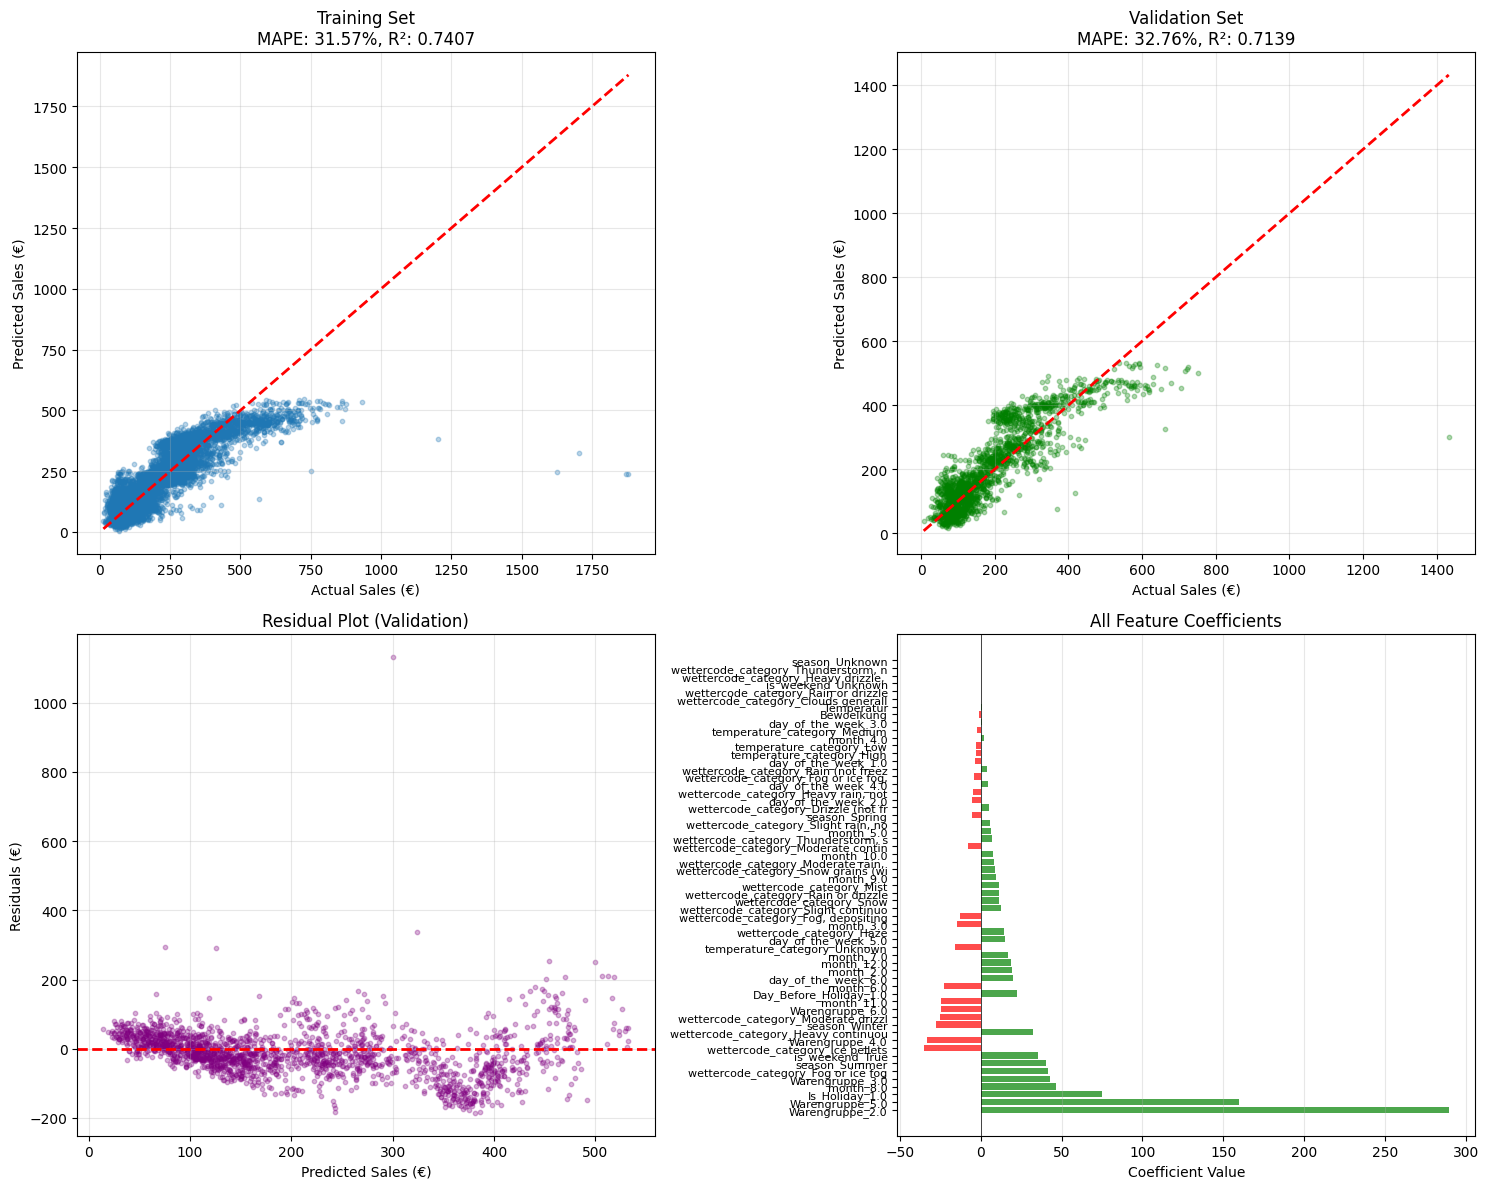

✓ Visualizations saved as 'baseline_model_simplified_results.png'


In [74]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted (Training)
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.3, s=10)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales (€)')
axes[0, 0].set_ylabel('Predicted Sales (€)')
axes[0, 0].set_title(f'Training Set\nMAPE: {train_mape:.2f}%, R²: {train_r2:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Validation)
axes[0, 1].scatter(y_val, y_val_pred, alpha=0.3, s=10, color='green')
axes[0, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Sales (€)')
axes[0, 1].set_ylabel('Predicted Sales (€)')
axes[0, 1].set_title(f'Validation Set\nMAPE: {val_mape:.2f}%, R²: {val_r2:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals
residuals = y_val - y_val_pred
axes[1, 0].scatter(y_val_pred, residuals, alpha=0.3, s=10, color='purple')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Sales (€)')
axes[1, 0].set_ylabel('Residuals (€)')
axes[1, 0].set_title('Residual Plot (Validation)')
axes[1, 0].grid(True, alpha=0.3)

# 4. All features
top_features = feature_importance.head(len(feature_importance))  # Show all
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
axes[1, 1].barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels([f[:35] for f in top_features['Feature']], fontsize=8)
axes[1, 1].set_xlabel('Coefficient Value')
axes[1, 1].set_title('All Feature Coefficients')
axes[1, 1].axvline(x=0, color='black', linestyle='-', lw=0.5)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_model_simplified_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'baseline_model_simplified_results.png'")

---
## 11. Generate Predictions for Test Set

In [75]:
print("Generating predictions for test set...\n")

# Make predictions
test_predictions = lr_model.predict(X_test)

# Create Kaggle submission format (id + umsatz only)
# Get 'id' from original test data (before encoding)
if 'id' in test_data.columns:
    submission = pd.DataFrame({
        'id': test_data['id'].values,
        'umsatz': test_predictions
    })
else:
    # Fallback: generate sequential IDs if 'id' column doesn't exist
    submission = pd.DataFrame({
        'id': range(len(test_predictions)),
        'umsatz': test_predictions
    })

print(f"Test Set Predictions (Kaggle Format):")
print(f"  Total predictions: {len(submission):,}")
print(f"  Mean predicted sales: €{submission['umsatz'].mean():.2f}")
print(f"  Columns: {list(submission.columns)}")

print(f"\nFirst 10 predictions:")
print(submission.head(10))

# Save
submission.to_csv('baseline_predictions_simplified.csv', index=False)
print(f"\n✓ Saved to: baseline_predictions_simplified.csv")
print(f"   Format: id, umsatz (ready for Kaggle submission)")

Generating predictions for test set...

Test Set Predictions (Kaggle Format):
  Total predictions: 1,830
  Mean predicted sales: €172.98
  Columns: ['id', 'umsatz']

First 10 predictions:
   id     umsatz
0   0  90.539563
1   1  91.996914
2   2  91.837047
3   3  87.180710
4   4  87.705741
5   5  90.141421
6   6  95.893556
7   7  88.991130
8   8  89.730911
9   9  87.409481

✓ Saved to: baseline_predictions_simplified.csv
   Format: id, umsatz (ready for Kaggle submission)


---
## 12. Summary

In [76]:
print("="*80)
print("SIMPLIFIED BASELINE MODEL - SUMMARY")
print("="*80)

print(f"\n📊 MODEL: Linear Regression (Simplified)")
print(f"   Features: {len(feature_cols)} (vs. 116 in full model)")
print(f"   Training samples: {len(X_train):,}")

print(f"\n📈 PERFORMANCE (Validation Set):")
print(f"   MAPE: {val_mape:.2f}%")
print(f"   R²: {val_r2:.4f}")
print(f"   Adjusted R²: {val_adj_r2:.4f}")
print(f"   MAE: €{val_mae:.2f}")

print(f"\n✅ OUTPUTS:")
print(f"   ✓ baseline_predictions_simplified.csv - Test predictions")
print(f"   ✓ baseline_model_simplified_results.png - Visualizations")

print(f"\n📝 INTERPRETATION:")
print(f"   The simplified model with {len(feature_cols)} features explains {val_r2*100:.1f}% of variance.")
print(f"   Average prediction error is {val_mape:.1f}%.")
print(f"   Compare with full 116-feature model to evaluate complexity vs. performance.")

print(f"\n" + "="*80)
print(f"✅ SIMPLIFIED BASELINE MODEL COMPLETE!")
print(f"="*80)

SIMPLIFIED BASELINE MODEL - SUMMARY

📊 MODEL: Linear Regression (Simplified)
   Features: 59 (vs. 116 in full model)
   Training samples: 7,493

📈 PERFORMANCE (Validation Set):
   MAPE: 32.76%
   R²: 0.7139
   Adjusted R²: 0.7044
   MAE: €49.55

✅ OUTPUTS:
   ✓ baseline_predictions_simplified.csv - Test predictions
   ✓ baseline_model_simplified_results.png - Visualizations

📝 INTERPRETATION:
   The simplified model with 59 features explains 71.4% of variance.
   Average prediction error is 32.8%.
   Compare with full 116-feature model to evaluate complexity vs. performance.

✅ SIMPLIFIED BASELINE MODEL COMPLETE!
